In [108]:
#importing necessary libraries and packages                   
import pandas as pd, numpy as np             # Data manipulation 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA        
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns                        # Graphing

import warnings
sns.set(style="white")  


# ignore all warnings
warnings.filterwarnings("ignore")


In [109]:
songs = pd.read_excel("Songs_2024.xlsx", sheet_name="spotify songs")

In [110]:
#getting a overview of dataset
songs.head()

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2019,Cruel Summer,100,Lover,Taylor Swift,['pop'],100,0.552,0.702,9.0,75.0,1.0,0.1570,0.11700,0.000021,0.1050,0.564,169.994,178427.0
1,2020,august,93,folklore,Taylor Swift,['pop'],100,0.532,0.623,5.0,96.0,1.0,0.0331,0.53800,0.000073,0.0925,0.403,89.937,261923.0
2,2022,Anti-Hero,93,Midnights,Taylor Swift,['pop'],100,0.637,0.643,4.0,81.0,1.0,0.0519,0.13000,0.000002,0.1420,0.533,97.008,200690.0
3,2022,I'm Good (Blue),93,I'm Good (Blue),David Guetta,['big room'; 'dance pop'; 'edm'; 'pop'; 'pop d...,86,0.561,0.965,7.0,56.0,0.0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,175238.0
4,2016,Starboy,92,Starboy,The Weeknd,['canadian contemporary r&b'; 'canadian pop'; ...,94,0.679,0.587,7.0,84.0,1.0,0.2760,0.14100,0.000006,0.1370,0.486,186.003,230453.0


In [111]:
#getting information about data types in dataset
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2202 entries, 0 to 2201
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               2202 non-null   int64  
 1   track_name         2202 non-null   object 
 2   track_popularity   2202 non-null   int64  
 3   album              2202 non-null   object 
 4   artist_name        2202 non-null   object 
 5   artist_genres      2202 non-null   object 
 6   artist_popularity  2202 non-null   int64  
 7   danceability       2201 non-null   float64
 8   energy             2201 non-null   float64
 9   key                2201 non-null   float64
 10  loudness           2201 non-null   float64
 11  mode               2201 non-null   float64
 12  speechiness        2201 non-null   float64
 13  acousticness       2201 non-null   float64
 14  instrumentalness   2201 non-null   float64
 15  liveness           2201 non-null   float64
 16  valence            2201 

Feature transformation according to Spotify's API feature definition 

In [112]:
# drop the rows in the dataset where there are nulls
songs = songs.dropna()

# dropping songs with 0 popularity that are just mistakes
songs = songs[songs['track_popularity'] > 0]

# #instrumentalness above 0.5 is considered instrumental
songs['instrumentalness'] = songs['instrumentalness'].apply(lambda x: 1 if x > 0.5 else 0)

# #liveness above 0.8 is considered live
songs['liveness'] = songs['liveness'].apply(lambda x: 1 if x > 0.8 else 0)

# acousticness above 0.7 is considered acoustic
songs['acousticness'] = songs['acousticness'].apply(lambda x: 1 if x > 0.7 else 0)

# key is a categorical variable - not mandatory as we're using Random Forest in the final version
#songs['key'] = songs['key'].astype('object')
#songs = pd.get_dummies(songs, columns=['key'])

# statistical overview of data
songs.describe()

,year,track_popularity,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000
mean,2010.919289,71.001368,72.754674,0.660063,0.694726,5.273598,72.974920,0.596899,0.097870,0.032376,0.011400,0.002736,0.536243,120.675695,226197.903329
std,6.646878,11.576211,12.222131,0.141366,0.165213,3.626862,15.697087,0.490633,0.092359,0.177036,0.106184,0.052247,0.227915,27.776252,42117.570673
min,2000.000000,1.000000,29.000000,0.162000,0.051900,0.000000,-56.000000,0.000000,0.022500,0.000000,0.000000,0.000000,0.037700,60.019000,97393.000000
25%,2005.000000,65.000000,65.000000,0.571000,0.588000,2.000000,64.000000,0.000000,0.038200,0.000000,0.000000,0.000000,0.361000,98.540000,200400.000000
50%,2011.000000,72.000000,74.000000,0.670000,0.712000,5.000000,74.000000,1.000000,0.056900,0.000000,0.000000,0.000000,0.541000,120.003000,221773.000000
75%,2017.000000,79.000000,82.000000,0.760000,0.822000,8.000000,83.000000,1.000000,0.116000,0.000000,0.000000,0.000000,0.722000,137.621000,245867.000000
max,2022.000000,100.000000,100.000000,0.975000,0.999000,11.000000,132.000000,1.000000,0.576000,1.000000,1.000000,1.000000,0.974000,210.857000,688453.000000


In [113]:
#Approach to artist_genre: genre_score, if you dont want to follow this approach, just dont execute this cell
# Block to transform genres into a genre_score
genre_dict = {}

# Iterate over each genre string
for genre in songs["artist_genres"]:
    
    # Remove the square brackets and split the string by '; ' to get a list of genres
    genre_list = genre.strip('[]').split('; ')
    
    # Iterate over each genre in the genre_list
    for genre_item in genre_list:
        # Remove the single quotation marks from the genre_item
        genre_item = genre_item.strip("'")
        
        # Check if the genre is already in the genre_dict
        if genre_item in genre_dict:
            # If it is, increment the count by 1
            genre_dict[genre_item] += 1
        else:
            # If it is not, add the genre to the genre_dict with a count of 1
            genre_dict[genre_item] = 1

# Sort the genre_dict in descending order based on the counts
genre_dict = dict(sorted(genre_dict.items(), key=lambda x: x[1], reverse=True))

# Function to calculate the genre score
def calculate_genre_score(genres):
    genre_list = genres.strip('[]').split('; ')
    genre_list = [genre.strip("'") for genre in genre_list]
    return sum(genre_dict.get(genre, 0) for genre in genre_list)

# Apply the calculate_genre_score function to the "artist_genres" column and assign the result to the "genre_score" column
songs["genre_score"] = songs["artist_genres"].apply(calculate_genre_score)

songs.head()

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre_score
0,2019,Cruel Summer,100,Lover,Taylor Swift,['pop'],100,0.552,0.702,9.0,75.0,1.0,0.1570,0,0,0,0.564,169.994,178427.0,935
1,2020,august,93,folklore,Taylor Swift,['pop'],100,0.532,0.623,5.0,96.0,1.0,0.0331,0,0,0,0.403,89.937,261923.0,935
2,2022,Anti-Hero,93,Midnights,Taylor Swift,['pop'],100,0.637,0.643,4.0,81.0,1.0,0.0519,0,0,0,0.533,97.008,200690.0,935
3,2022,I'm Good (Blue),93,I'm Good (Blue),David Guetta,['big room'; 'dance pop'; 'edm'; 'pop'; 'pop d...,86,0.561,0.965,7.0,56.0,0.0,0.0343,0,0,0,0.304,128.040,175238.0,1659
4,2016,Starboy,92,Starboy,The Weeknd,['canadian contemporary r&b'; 'canadian pop'; ...,94,0.679,0.587,7.0,84.0,1.0,0.2760,0,0,0,0.486,186.003,230453.0,1063


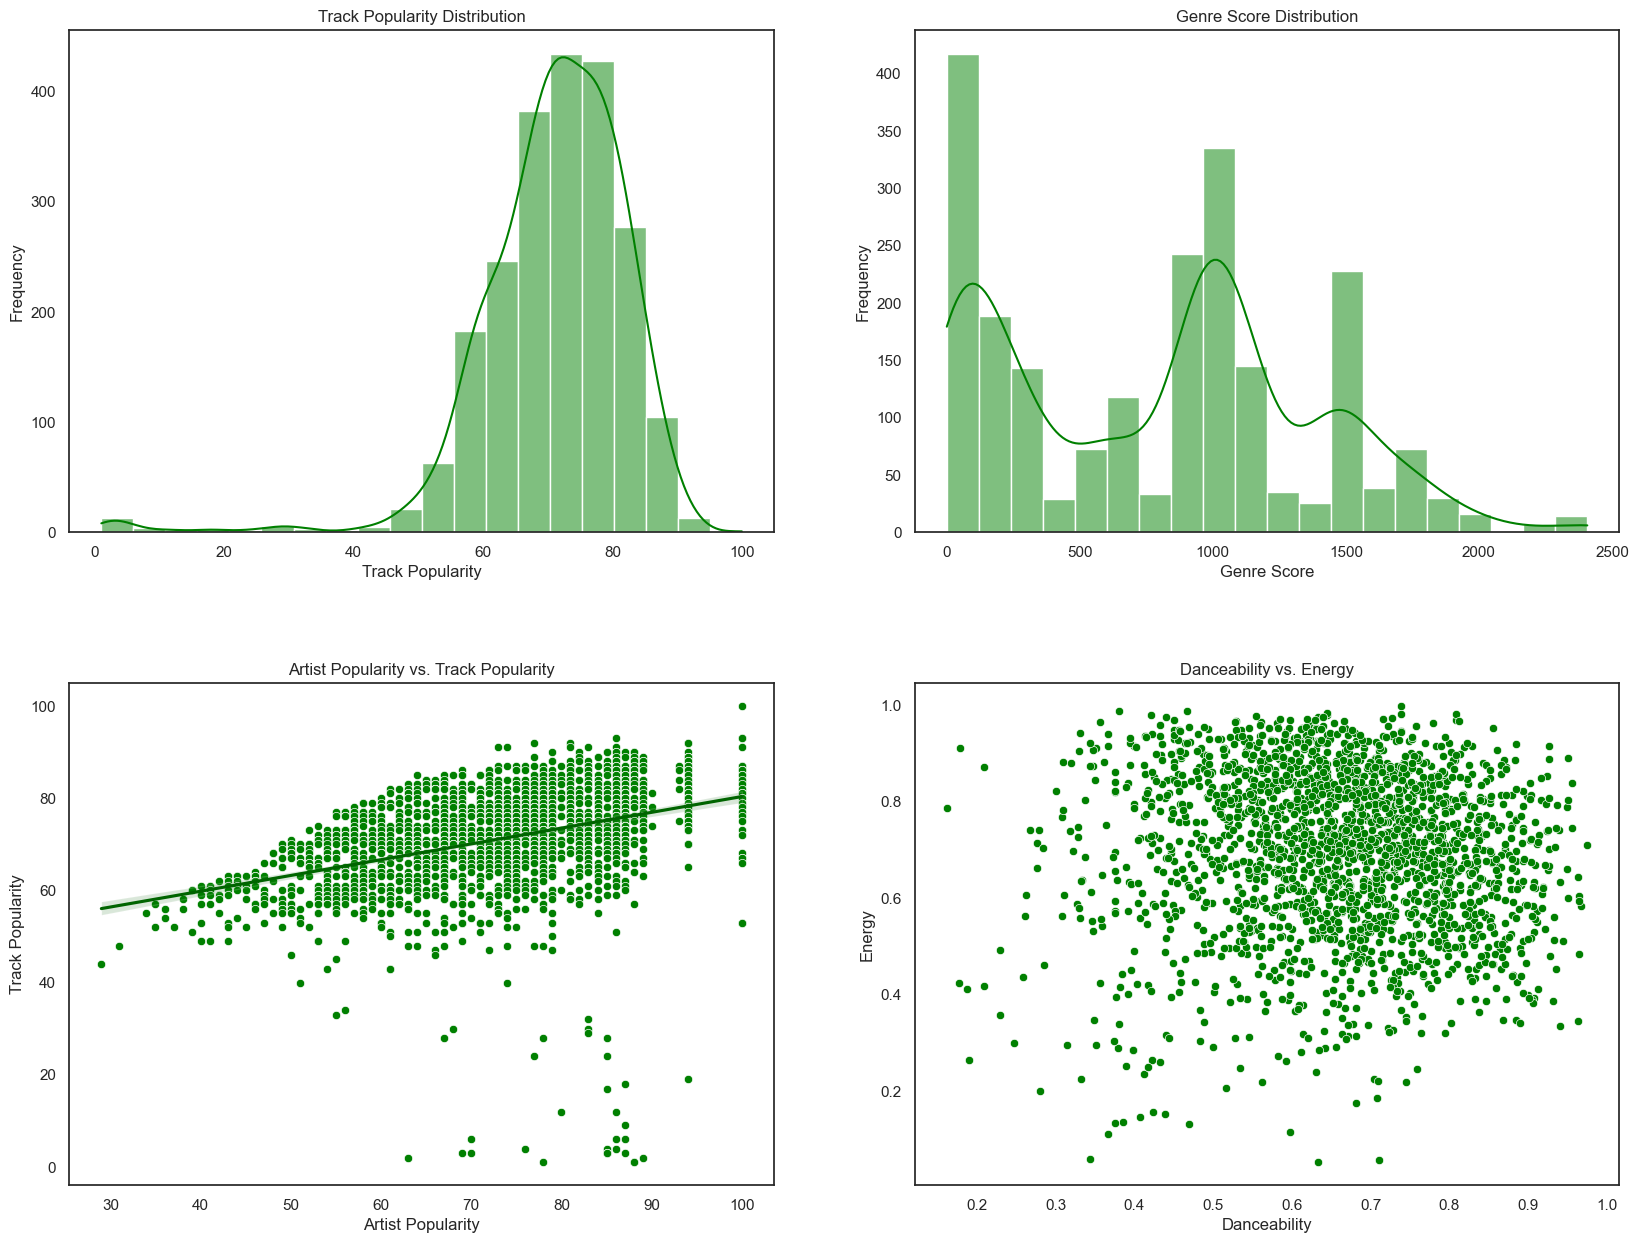

In [114]:
# Removing grid lines and adding a trend line to the Artist Popularity vs. Track Popularity chart

# Create a new figure to hold the adjusted plots without grid lines and with a trend line
fig, axs = plt.subplots(2, 2, figsize=(20, 15), gridspec_kw={'hspace': 0.3, 'wspace': 0.2})

# Adjust the layout
plt.tight_layout(pad=6.0)

# Popularity Distribution without grid lines
sns.histplot(songs['track_popularity'], bins=20, kde=True, color="green", ax=axs[0, 0])
axs[0, 0].set_title('Track Popularity Distribution')
axs[0, 0].set_xlabel('Track Popularity')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].grid(False)  # Remove grid lines

# Genre Score Distribution without grid lines
sns.histplot(songs['genre_score'], bins=20, kde=True, color="green", ax=axs[0, 1])
axs[0, 1].set_title('Genre Score Distribution')
axs[0, 1].set_xlabel('Genre Score')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].grid(False)  # Remove grid lines

# Artist Popularity vs. Track Popularity without grid lines and with a trend line
sns.scatterplot(data=songs, x='artist_popularity', y='track_popularity', color="green", ax=axs[1, 0])
sns.regplot(data=songs, x='artist_popularity', y='track_popularity', scatter=False, color="darkgreen", ax=axs[1, 0])
axs[1, 0].set_title('Artist Popularity vs. Track Popularity')
axs[1, 0].set_xlabel('Artist Popularity')
axs[1, 0].set_ylabel('Track Popularity')
axs[1, 0].grid(False)  # Remove grid lines

# Danceability and Energy Levels without grid lines
sns.scatterplot(data=songs, x='danceability', y='energy', color="green", ax=axs[1, 1])
axs[1, 1].set_title('Danceability vs. Energy')
axs[1, 1].set_xlabel('Danceability')
axs[1, 1].set_ylabel('Energy')
axs[1, 1].grid(False)  # Remove grid lines

plt.show()

In [115]:
#Dropping the columns we don't need
songs = songs.drop(['year', 'duration_ms'], axis=1)

# Get the column names
numerical_columns = list(songs.select_dtypes(include=[np.number]).columns)
categorical_columns = list(songs.select_dtypes(include=[object]).columns)

# Create a new dataframe with only the numerical columns
numerical = pd.DataFrame(songs[numerical_columns])
numerical_columns

#Drop from numerical instrumentalness, liveness, mode, key and loudness
# numerical = numerical.drop(['instrumentalness', 'liveness', 'mode', 'key', 'loudness', 'speechiness',], axis=1)

['track_popularity',
 'artist_popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'genre_score']

In [116]:
# Calculate the correlation matrix
corr_matrix = numerical.corr()

# Rest of the code...
corr_matrix['track_popularity'].sort_values(ascending=False)

track_popularity     1.000000
artist_popularity    0.361310
genre_score          0.089191
loudness             0.024057
acousticness         0.023129
danceability         0.018969
mode                 0.013190
liveness            -0.001515
instrumentalness    -0.004466
tempo               -0.016368
speechiness         -0.019658
key                 -0.044657
valence             -0.066489
energy              -0.075962
Name: track_popularity, dtype: float64

Text(0.5, 1.0, 'Correlation Matrix')

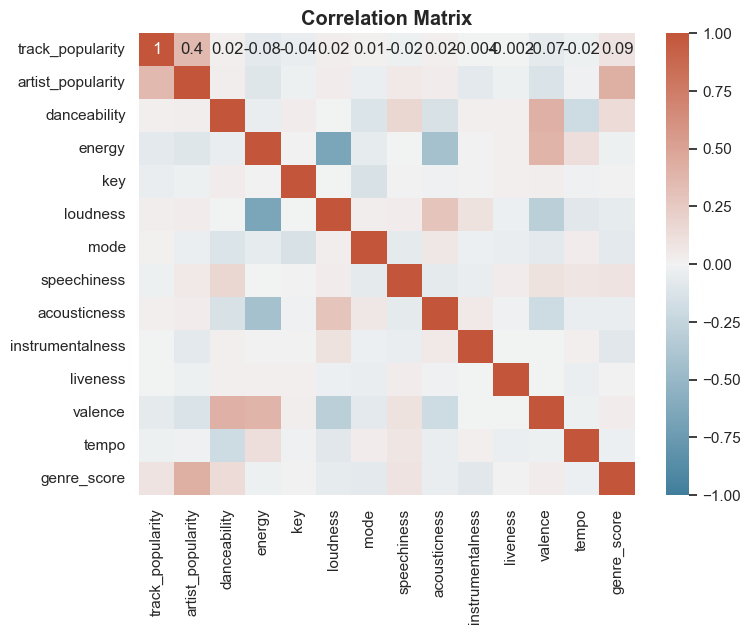

In [117]:
# Plotting correlation heatmap using seaborn
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap=cmap)
plt.title("Correlation Matrix", fontweight='bold', fontsize='large')

In [118]:
def get_stats(df):
    # print stats for various metrics
    print(f"There are {df.shape[0]} rows")
    print(f"There are {df['artist_name'].unique().shape} unique artists")
    print(f"There are {df['track_popularity'].unique().shape} track_popularity scores")
    print(f"The mean track_popularity score is {df['track_popularity'].mean()}")
    print(f"There are {df[df['track_popularity'] > 55]['track_popularity'].count()} songs with a track_popularity score > 55")
    print(f"There are {df[df['track_popularity'] > 75]['track_popularity'].count()} songs with a track_popularity score > 75")
    print(f"Only {(df[df['track_popularity'] > 80]['track_popularity'].count() / df.shape[0])*100:.2f} % of songs have a track_popularity score > 80")
    print(f"Only {(df[df['track_popularity'] > 88]['track_popularity'].count() / df.shape[0])*100:.2f} % of songs have a track_popularity score > 88")
    #printing number of songs with popularity score = 0
    print('Number of songs with 0 as popularity value: ', len(df[df["track_popularity"] == 0]))
    
# plot univariate dists for several independent variables
def plot_univ_dists(df, cutoff):
    track_popularity_cutoff = cutoff
    
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    fig.suptitle('Histograms and Univariate Distributions of Important Features')
    sns.distplot(df[df['track_popularity'] < track_popularity_cutoff]['danceability'])
    sns.distplot(df[df['track_popularity'] > track_popularity_cutoff]['danceability'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['track_popularity'] < track_popularity_cutoff]['valence'])
    sns.distplot(df[df['track_popularity'] > track_popularity_cutoff]['valence'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['track_popularity'] < track_popularity_cutoff]['acousticness'])
    sns.distplot(df[df['track_popularity'] > track_popularity_cutoff]['acousticness'])
    plt.show()
    
    
# plot pairplot for subsection of df rows and columns
def plot_pairplot(df, rows, cutoff):
    # not it looks MUCH better to run this function in jupyter
    df = df.copy()
    
    df['pop_bin'] = np.where(df['track_popularity'] > cutoff, "Popular", "Not_Popular")
    
    cols_for_pp = ['danceability', 'energy', 'instrumentalness',
       'loudness','valence', 'track_popularity', 'pop_bin']

    sns.pairplot(df.loc[:rows, cols_for_pp], hue='pop_bin', size=2)

    plt.show()

# plot a heatmap of the correlations between features as well as dependent variable
def plot_heatmap(df):
    # note this looks better in jupyter as well
    plt.figure(figsize = (16,6))
    sns.heatmap(df.corr(), cmap="coolwarm", annot=True)
    plt.show()

There are 2193 rows
There are (890,) unique artists
There are (70,) track_popularity scores
The mean track_popularity score is 71.00136798905609
There are 2069 songs with a track_popularity score > 55
There are 824 songs with a track_popularity score > 75
Only 18.06 % of songs have a track_popularity score > 80
Only 1.69 % of songs have a track_popularity score > 88
Number of songs with 0 as popularity value:  0


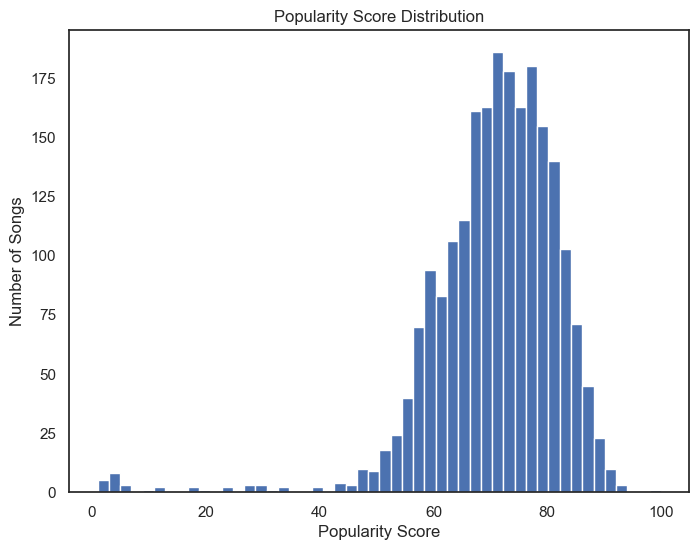

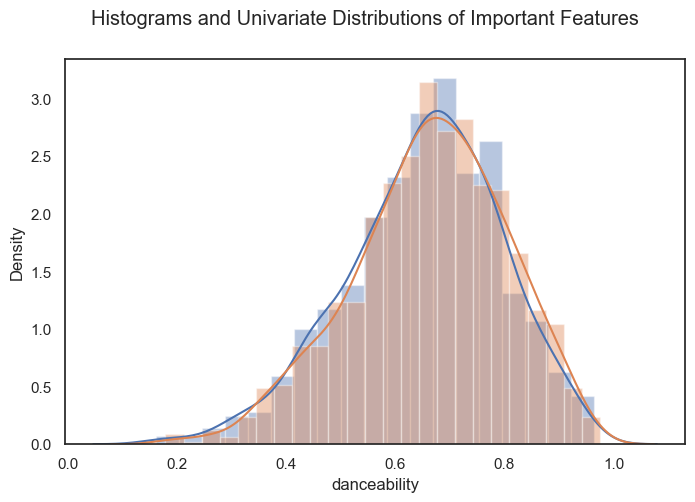

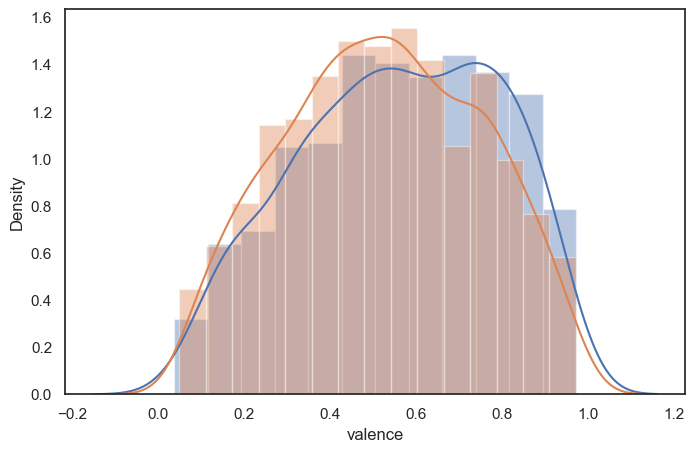

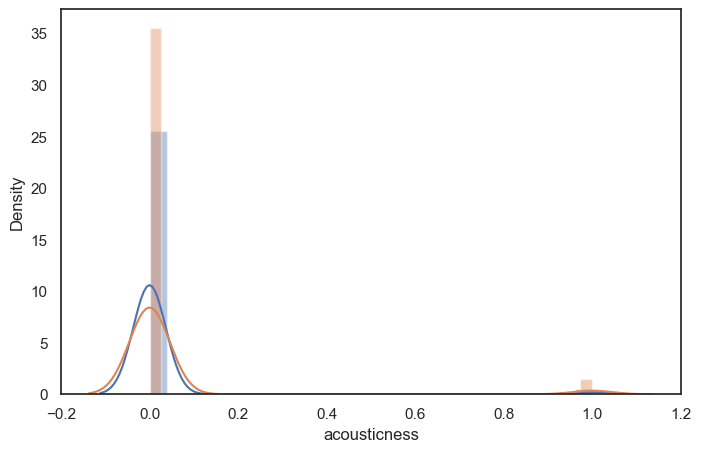

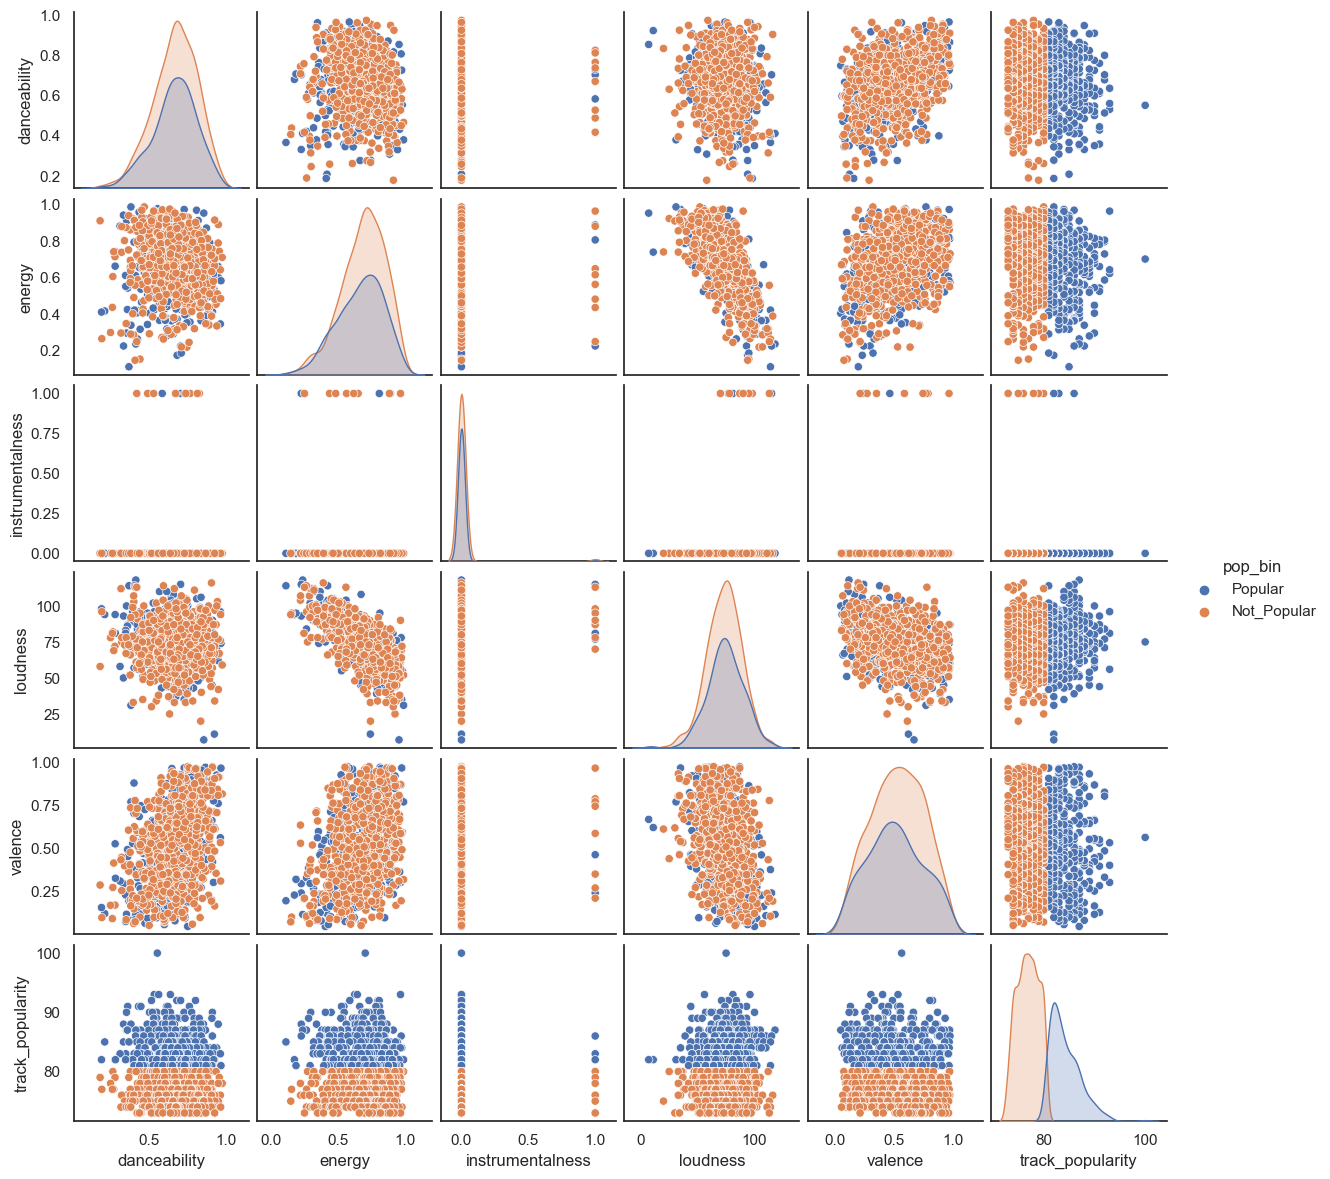

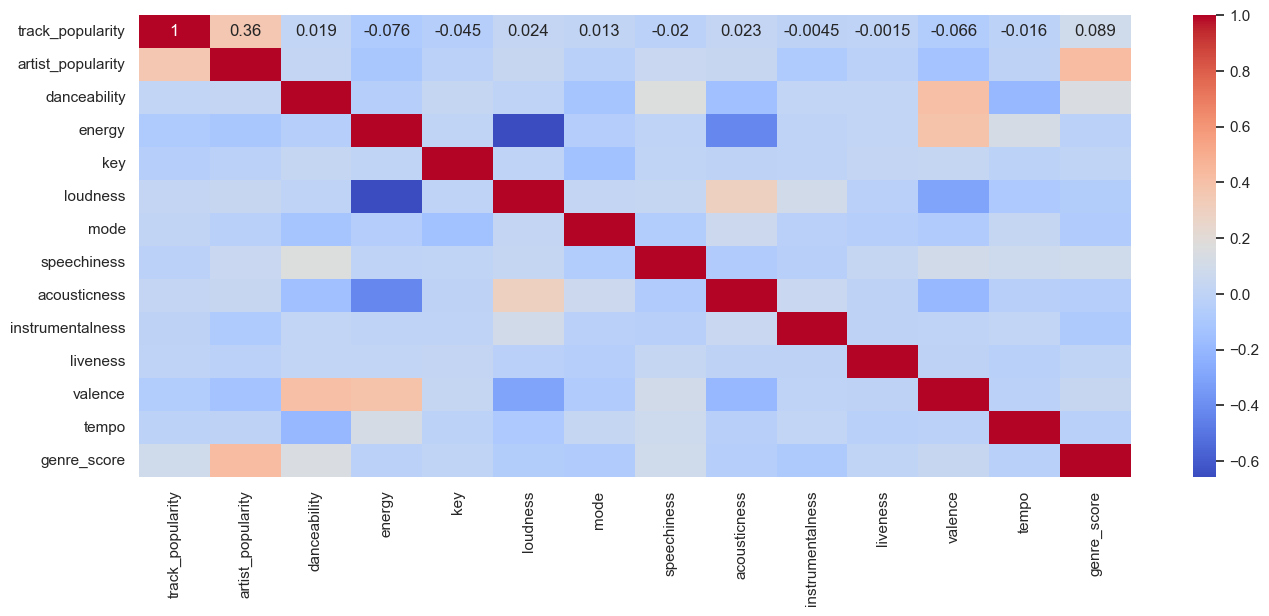

In [119]:
get_stats(songs)
# plotting histogram for popularity score distribution
songs['track_popularity'].plot(kind='hist', bins=50)
plt.xlabel('Popularity Score')
plt.ylabel('Number of Songs')
plt.title('Popularity Score Distribution')
plt.show()
plot_univ_dists(songs, 68)
plot_pairplot(songs, 1000, 80)
plot_heatmap(numerical)

# Data scalling and training process


In [120]:
df_cleaned = numerical.copy()

# # Then drop the original track_popularity column:
df_cleaned = df_cleaned.drop('track_popularity', axis=1)

ss = StandardScaler().fit(df_cleaned)
X_std = ss.transform(df_cleaned)

# Assuming df_cleaned is your DataFrame
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

# Display the original and scaled DataFrames
print("Original DataFrame:")
print(df_cleaned)

print("\nScaled DataFrame:")
print(df_scaled)

Original DataFrame:
      artist_popularity  danceability  energy   key  loudness  mode  \
0                   100         0.552   0.702   9.0      75.0   1.0   
1                   100         0.532   0.623   5.0      96.0   1.0   
2                   100         0.637   0.643   4.0      81.0   1.0   
3                    86         0.561   0.965   7.0      56.0   0.0   
4                    94         0.679   0.587   7.0      84.0   1.0   
...                 ...           ...     ...   ...       ...   ...   
2189                 63         0.784   0.430  10.0      94.0   0.0   
2190                 89         0.587   0.561   0.0      81.0   1.0   
2191                 78         0.810   0.714   2.0      59.0   1.0   
2192                 88         0.671   0.336  10.0      92.0   0.0   
2193                 88         0.634   0.285   9.0     114.0   0.0   

      speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0          0.1570             0               

In [121]:
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(df_scaled)

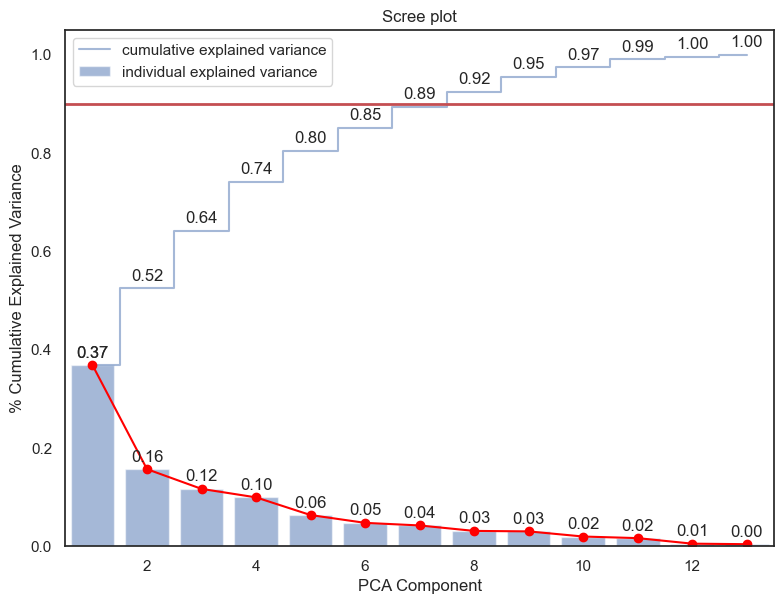

In [122]:
# Explained variance
plt.rcParams["figure.figsize"] = (8, 6)
plt.bar(range(1,sklearn_pca.n_components_+1), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(1,sklearn_pca.n_components_+1), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], alpha=0.5, where='mid',label='cumulative explained variance')
plt.axhline(y=0.9, linewidth=2, color = 'r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
for i, ratio in enumerate(sklearn_pca.explained_variance_ratio_):
    plt.text(i+1, ratio + 0.01, f'{ratio:.2f}', ha='center', va='bottom')
for i, ratio in enumerate([sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)]):
    plt.text(i+1, ratio + 0.01, f'{ratio:.2f}', ha='center', va='bottom')
plt.xlim([0.5, sklearn_pca.n_components_+0.5])
plt.legend(loc='best')
plt.tight_layout()

# Scree plot 
plt.plot(
    range(1,len(sklearn_pca.explained_variance_ratio_ )+1),
    sklearn_pca.explained_variance_ratio_,
    c='red', marker='o'
)
 
plt.xlabel('PCA Component')
plt.ylabel('% Cumulative Explained Variance')
plt.title('Scree plot')
plt.show()

In [123]:
VARIANCE_TO_KEEP = 0.69
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
retained_components_number = keep_recommend

Number of components to keep to retain 69.0% of the variance: 3 out of the original 13


In [124]:
sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

In [125]:
# Shows factor loadings = correlations between variables and factors
print ("Factor loadings:")

# loadings = eigenvectors * sqrt(eigenvalues)
loadings=sklearn_pca_final.components_.T * np.sqrt(sklearn_pca_final.explained_variance_)

dfloadings=pd.DataFrame(loadings.T,columns = df_scaled.columns)
index_list=[]
for n in range(retained_components_number):
    index_list.append("PC"+str(n+1))

dfloadings.index = index_list
dfloadings

Factor loadings:


,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_score
PC1,0.138663,-0.282318,-0.831847,-0.051532,0.759437,0.160499,-0.119577,0.624291,0.074292,-0.045771,-0.661778,-0.101652,-0.069426
PC2,-0.582567,-0.585553,0.256235,-0.104355,-0.170361,0.304095,-0.359379,0.022030,0.146705,-0.049090,-0.176120,0.292235,-0.678312
PC3,-0.567123,0.510382,-0.183751,0.195504,0.283158,-0.199501,0.086895,0.077878,0.323319,0.080477,0.349447,-0.379478,-0.447186


In [126]:
# Hide values so that it is clearer
dfloadings.where(abs(dfloadings) > 0.3  , "").T

,PC1,PC2,PC3
artist_popularity,,-0.582567,-0.567123
danceability,,-0.585553,0.510382
energy,-0.831847,,
key,,,
loudness,0.759437,,
mode,,0.304095,
speechiness,,-0.359379,
acousticness,0.624291,,
instrumentalness,,,0.323319
liveness,,,


In [127]:
# Communalities
commun=[]

for col in dfloadings.columns:
    commun.append((dfloadings.iloc[0:3][col]**2).sum())
    
dfcommun = pd.DataFrame(commun,index=dfloadings.columns, columns=["Communalities"])
dfcommun.sort_values("Communalities", ascending=False)

,Communalities
energy,0.791390
loudness,0.685946
danceability,0.683065
artist_popularity,0.680240
genre_score,0.664903
valence,0.591081
acousticness,0.396289
tempo,0.239738
mode,0.158034
speechiness,0.151003


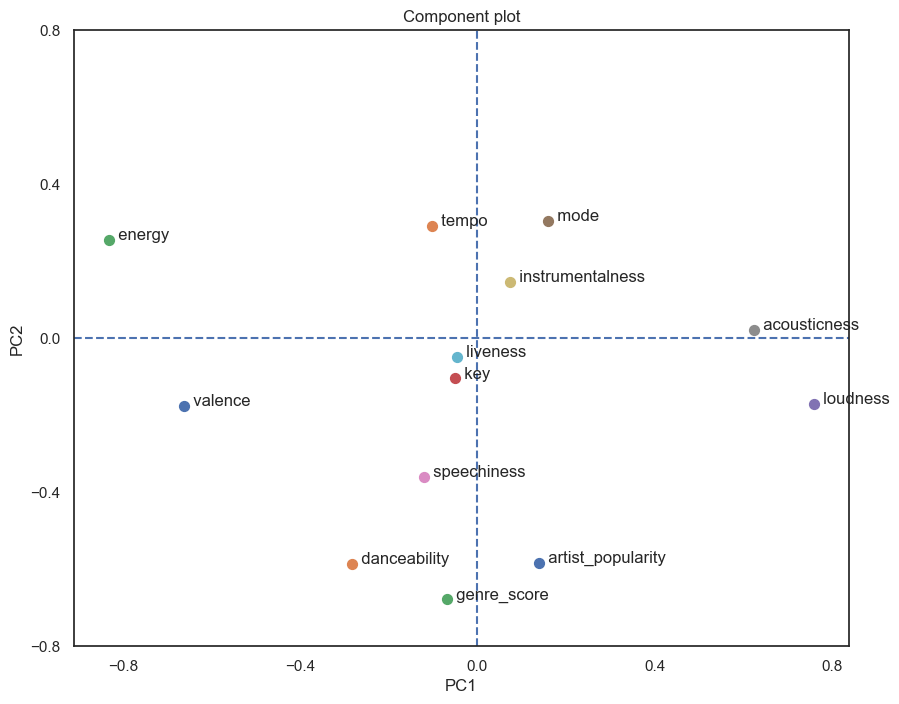

In [128]:
# Get the loadings of x and y axes
dfloadT = dfloadings.T

xs = dfloadT.PC1
ys = dfloadT.PC2
 
plt.figure(figsize = (10, 8))
plt.axvline(x = 0, color = 'b', linestyle = 'dashed')
plt.axhline(y = 0, color = 'b', linestyle = 'dashed')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(dfloadings.columns):
    plt.scatter(xs[i], ys[i], s=50)
    plt.text(xs[i], ys[i], "  " + varnames)

# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('Component plot')
plt.show()

### Popularity threshold transformation

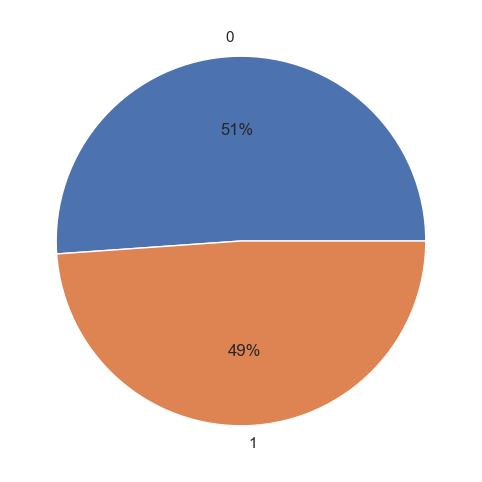

In [129]:
# Transform track_popularity column in the df to binary one through a function, where we can set the cutoff for which we set 0 or 1 ("unpopular" or "popular")
def binarize_popularity(df, cutoff):
    df['pop_bin'] = np.where(songs['track_popularity'] > cutoff, 1, 0)
    return df

cutoff = 72

# Apply the function to the df
df_scaled = binarize_popularity(df_scaled, cutoff)
acc="accuracy"

unique, counts = np.unique(df_scaled["pop_bin"], return_counts=True)
plt.pie(counts, labels=unique, autopct='%.0f%%');

In [130]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set the random seed
np.random.seed(37)

# Assuming df_scaled is your DataFrame
# Separate features from response field
X, y = df_scaled.iloc[:,:-1], df_scaled.iloc[:,-1]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression

In [131]:
#importing necessary libraries to perform logistic regression
from sklearn import linear_model, metrics

log_reg = linear_model.LogisticRegression(solver = 'lbfgs', max_iter = 1000)

#train the model using training set
log_reg.fit(X_train, y_train)

#making predictions on the testing set
y_pred = log_reg.predict(X_test)

#printing accuracy of algorithm
accLR = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
print("Logistic Regression Model Accuracy (in %):", accLR)
accLR = accLR/100

Logistic Regression Model Accuracy (in %): 71.58


              precision    recall  f1-score   support

           0       0.72      0.72      0.72       280
           1       0.71      0.71      0.71       269

    accuracy                           0.72       549
   macro avg       0.72      0.72      0.72       549
weighted avg       0.72      0.72      0.72       549



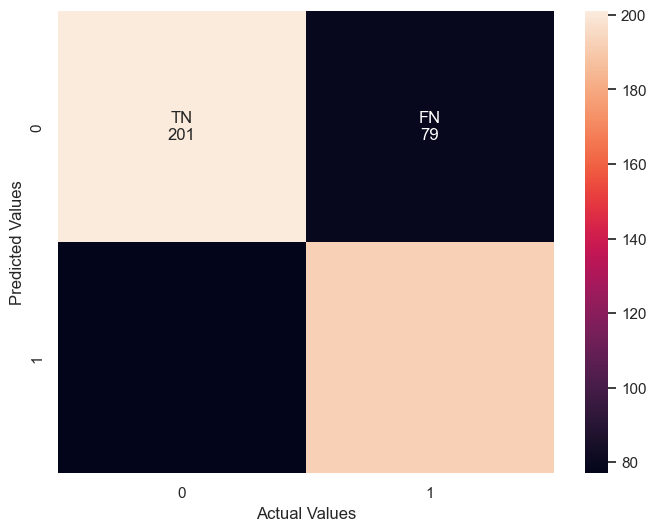

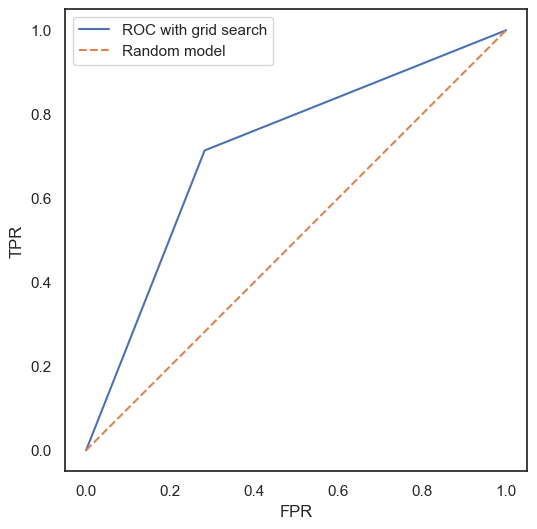

In [132]:
#printing confusion matrix and classification report

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, annot=labels, fmt='')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')

print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with grid search")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

**K Nearest Neighbors**

In [133]:
parameters = {
    "n_neighbors": [34],
    "weights": ["uniform"]
}

gridsearch = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, verbose=2)
gridsearch.fit(X_train, y_train)
print("Best parameters: ", gridsearch.best_params_)

# Apply prediction 
train_preds_grid = gridsearch.predict(X_train)
predictions = gridsearch.predict(X_test) 


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................n_neighbors=34, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=34, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=34, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=34, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=34, weights=uniform; total time=   0.0s
Best parameters:  {'n_neighbors': 34, 'weights': 'uniform'}


              precision    recall  f1-score   support

           0       0.66      0.64      0.65       280
           1       0.64      0.66      0.65       269

    accuracy                           0.65       549
   macro avg       0.65      0.65      0.65       549
weighted avg       0.65      0.65      0.65       549



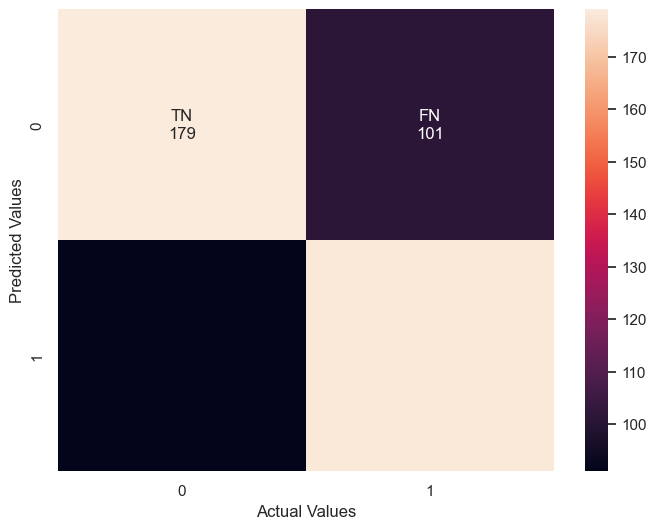

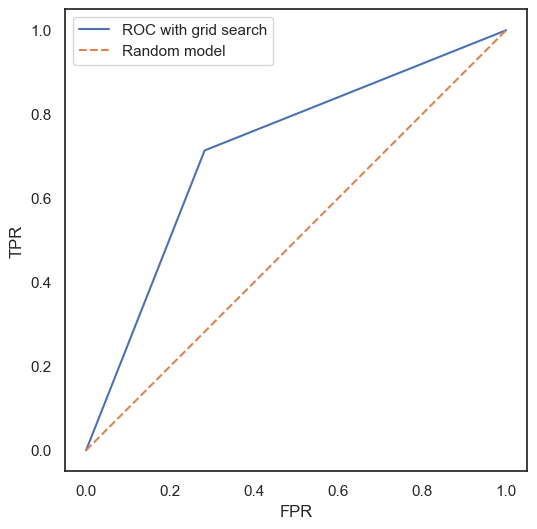

In [134]:

conf_mat = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, annot=labels, fmt='')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')

#printing confusion matrix and classification report
print(classification_report(y_test, predictions))

auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with grid search")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [135]:
#printing accuracy of algorithm
accKNN = round(metrics.accuracy_score(y_test, predictions) * 100,2)
print("KNN Model Accuracy (in %):", accKNN)
accKNN = accKNN/100

KNN Model Accuracy (in %): 65.03


Bagging with GridSearch


In [136]:
model = RandomForestClassifier(n_estimators=500, oob_score=True) 
model.fit(X_train, y_train)

param_grid = {'min_samples_leaf' :[9]}

BaggGrid = GridSearchCV(model, param_grid=param_grid, cv=5, scoring=acc, verbose=1) 
BaggGrid.fit(X_train,y_train)
print("Best param: ", BaggGrid.best_params_)
model = RandomForestClassifier(n_estimators = 200, oob_score = True,
                               min_samples_leaf = 9)
model.fit(X_train,y_train)
accBaggGrid=model.oob_score_
print("Accuracy OOB set - Bagging with Grid Searching: {0:.2%}".format(accBaggGrid))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best param:  {'min_samples_leaf': 9}
Accuracy OOB set - Bagging with Grid Searching: 65.75%


              precision    recall  f1-score   support

           0       0.74      0.71      0.73       280
           1       0.71      0.74      0.72       269

    accuracy                           0.72       549
   macro avg       0.73      0.73      0.72       549
weighted avg       0.73      0.72      0.72       549



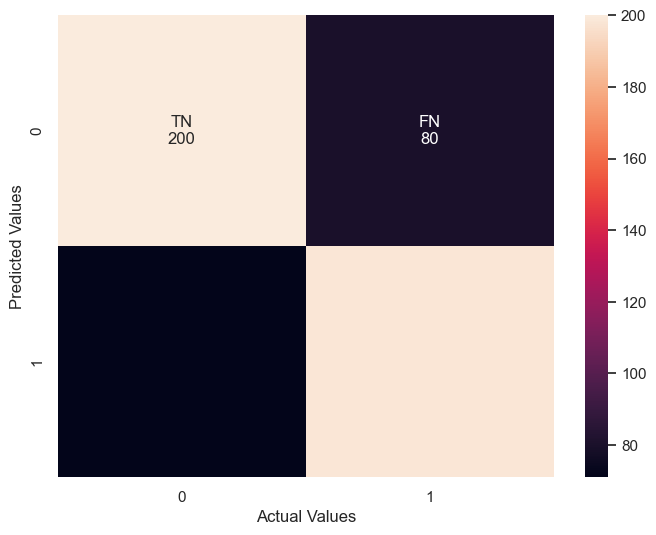

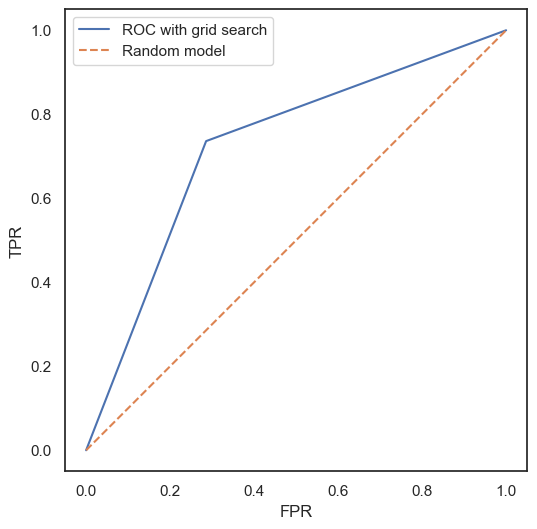

In [137]:
y_pred = BaggGrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, annot=labels, fmt='')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')

#printing confusion matrix and classification report
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with grid search")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [138]:
#printing accuracy of algorithm
accBaggGrid = accuracy_score(y_test, y_pred)

print("Bagging Model Accuracy (in %):", accBaggGrid * 100)

Bagging Model Accuracy (in %): 72.49544626593807


**Random Forest**

In [139]:
model = RandomForestClassifier(n_estimators=500, oob_score=True, max_features=8)
model.fit(X_train, y_train)

param_grid = {
    'min_samples_leaf' : [5], 
    'max_features' : [7],
}

RFGrid = GridSearchCV(model, param_grid=param_grid, cv=5, scoring=acc, verbose=1) 
RFGrid.fit(X_train,y_train)
print("Best param: ", RFGrid.best_params_)
model = RandomForestClassifier(n_estimators=200, oob_score=True, 
                               max_features=5, 
                               min_samples_leaf=7)
model.fit(X_train,y_train)

accRFGrid=model.oob_score_
print("Accuracy OOB set - RF with Grid Searching: {0:.2%}".format(accRFGrid))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best param:  {'max_features': 7, 'min_samples_leaf': 5}
Accuracy OOB set - RF with Grid Searching: 65.09%


              precision    recall  f1-score   support

           0       0.75      0.72      0.74       280
           1       0.72      0.74      0.73       269

    accuracy                           0.73       549
   macro avg       0.73      0.73      0.73       549
weighted avg       0.73      0.73      0.73       549



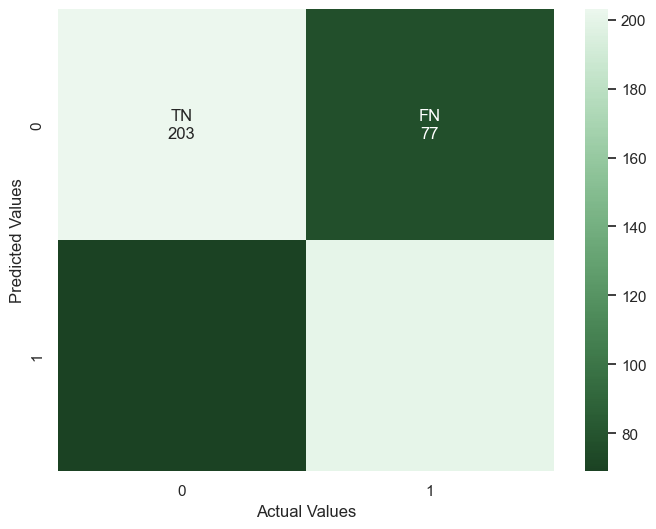

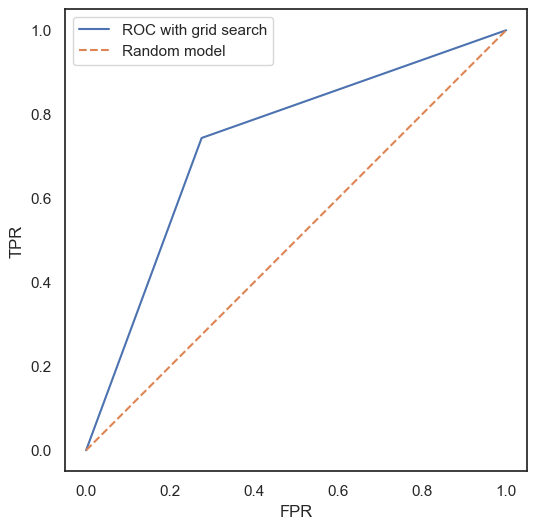

In [140]:
y_pred = RFGrid.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)


# Define a custom color map
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=.95, reverse=True, as_cmap=True)

# Draw heatmap using confusion matrix with the custom color map
sns.heatmap(conf_mat, annot=labels, fmt='', cmap=cmap)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')


#printing confusion matrix and classification report
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with grid search")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [141]:
#printing accuracy of algorithm
accRFGrid = accuracy_score(y_test, y_pred)

print("Random Forest Model Accuracy (in %):", accRFGrid * 100)

Random Forest Model Accuracy (in %): 73.40619307832422


In [142]:
feature_importances = model.feature_importances_
importance_list = sorted(zip(feature_importances, X.columns), reverse=True)

# Print feature importances|
for importance, feature in importance_list:
    print(feature, ": ", importance)

artist_popularity :  0.32720690831897364
genre_score :  0.13147856851560163
speechiness :  0.09593125475952025
energy :  0.08650576662989813
valence :  0.08180090492200007
danceability :  0.08087166653821094
tempo :  0.07494747116825788
loudness :  0.06665051499683736
key :  0.040661148689034476
mode :  0.013287150668664973
acousticness :  0.0005892408264022323
instrumentalness :  6.94039665984348e-05
liveness :  0.0



Boosting 

In [143]:
model = XGBClassifier(n_estimators=200)

model.fit(X_train, y_train)

params = {
        'subsample': [0.6],
        'max_depth': [3], 
        'learning_rate': [0.001]
        }

xgbGrid = GridSearchCV(model, params, cv = 5, scoring=acc, verbose=1)
xgbGrid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.001], 'max_depth': [3],
                         'subsample': [0.6]},
             scoring='accuracy', verbose=1)

In [144]:
print("Best set of hyperparameters: ", xgbGrid.best_params_)
XGB = XGBClassifier(n_estimators=200, learning_rate=xgbGrid.best_params_["learning_rate"],
                    max_depth=xgbGrid.best_params_["max_depth"],
                    subsample=xgbGrid.best_params_["subsample"])

XGB.fit(X_train, y_train)
predictions = XGB.predict(X_test)
accBoostGrid=accuracy_score(y_test, predictions)
print("Accuracy test set - Boosting with Grid Searching: {0:.2%}".format(accBoostGrid))

Best set of hyperparameters:  {'learning_rate': 0.001, 'max_depth': 3, 'subsample': 0.6}
Accuracy test set - Boosting with Grid Searching: 72.86%


              precision    recall  f1-score   support

           0       0.73      0.73      0.73       280
           1       0.72      0.72      0.72       269

    accuracy                           0.73       549
   macro avg       0.73      0.73      0.73       549
weighted avg       0.73      0.73      0.73       549



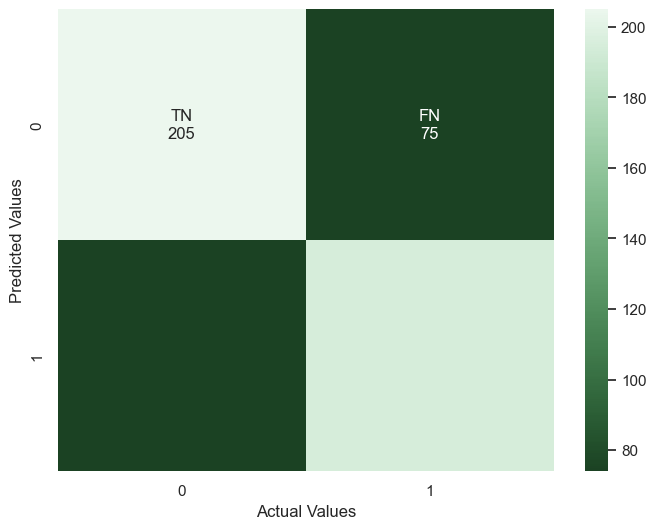

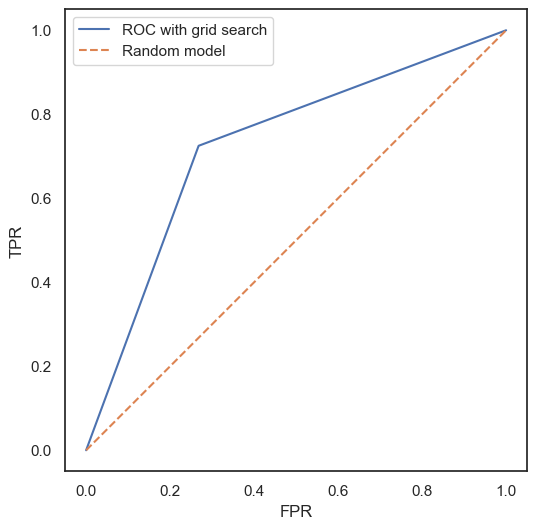

In [145]:
conf_mat = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)

# Define a custom color map
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=.95, reverse=True, as_cmap=True)

# Draw heatmap using confusion matrix with the custom color map
sns.heatmap(conf_mat, annot=labels, fmt='', cmap=cmap)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')

#printing confusion matrix and classification report
print(classification_report(y_test, predictions))

auc = roc_auc_score(y_test, predictions)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with grid search")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

**Decision Tree**

In [146]:
model = DecisionTreeClassifier() # by default Gini index, no random replication
model.fit(X_train, y_train)

param_grid = {'max_depth': [1]} 

param_grid = {
    'criterion': ['gini', 'entropy'],  # Split criterion: Gini impurity or entropy
    'splitter': ['best', 'random'],  # Strategy for splitting nodes: best or random
    'max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'max_leaf_nodes': [None, 10, 20, 30],  # Maximum number of leaf nodes
    'min_impurity_decrease': [0.0, 0.1, 0.2],  # Minimum impurity decrease required for split
    'ccp_alpha': [0.0, 0.1, 0.2]  # Complexity parameter used for Minimal Cost-Complexity Pruning
}

tree = GridSearchCV(model, param_grid, scoring=acc, cv=5 , n_jobs=1, verbose=1)
tree.fit(X_train,y_train)
print("Best param: ", tree.best_params_)
tree_pruned = DecisionTreeClassifier(max_depth=tree.best_params_["max_depth"], criterion="entropy")
tree_pruned.fit(X_train, y_train)
predictions = tree_pruned.predict(X_test)
accDTGrid=accuracy_score(y_test, predictions)
print("Accuracy of Test set (pruned) = {0:.2%}".format(accDTGrid))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best param:  {'max_depth': 1}
Accuracy of Test set (pruned) = 65.94%


              precision    recall  f1-score   support

           0       0.81      0.43      0.56       280
           1       0.60      0.90      0.72       269

    accuracy                           0.66       549
   macro avg       0.71      0.66      0.64       549
weighted avg       0.71      0.66      0.64       549



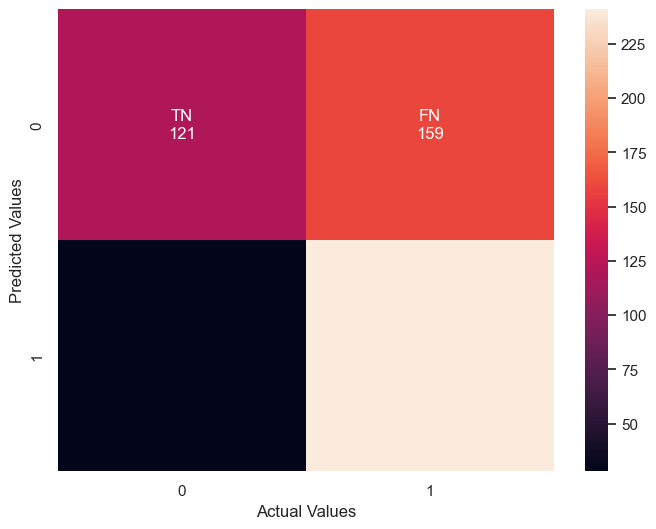

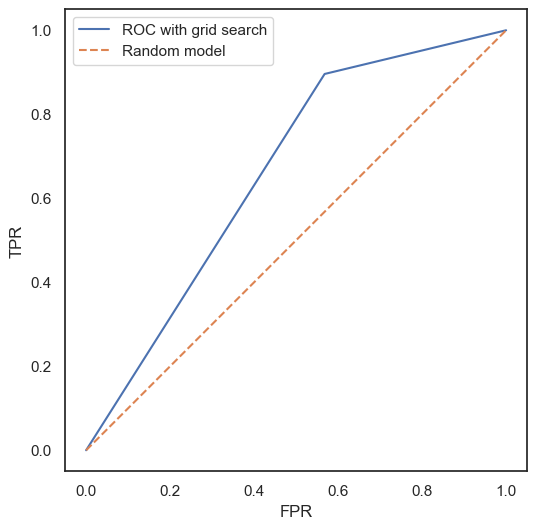

In [147]:
conf_mat = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, annot=labels, fmt='')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')

#printing confusion matrix and classification report
print(classification_report(y_test, predictions))

auc = roc_auc_score(y_test, predictions)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with grid search")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [148]:
#printing accuracy of algorithm
print("Decsision Tree Model Accuracy (in %):",accDTGrid*100)

Decsision Tree Model Accuracy (in %): 65.93806921675774


Summary

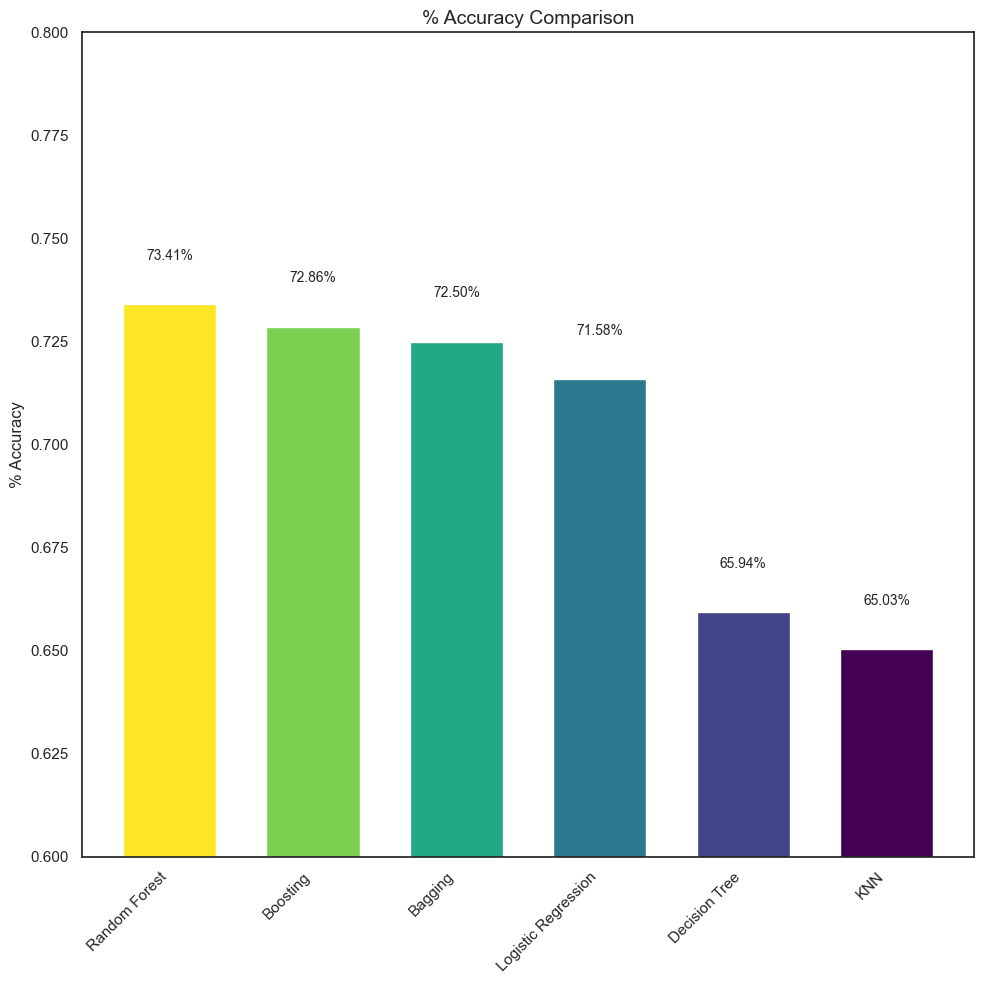

In [149]:
categ = ['Decision Tree', 'Bagging', 'Random Forest', 'Boosting', 'Logistic Regression', 'KNN']
values = [accDTGrid, accBaggGrid, accRFGrid, accBoostGrid, accLR, accKNN]
sorted_indices = np.argsort(values)[::-1]
sorted_categories = [categ[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]

# Define color scale in descending order
colors = plt.cm.viridis(np.linspace(1, 0, len(categ)))

plt.figure(figsize=(10, 10))
bar_width = 0.65  # Adjust the width of the bars
bars = plt.bar(np.arange(len(sorted_categories)), sorted_values, color=colors, width=bar_width)

# Adjusting spacing between bars
plt.xticks(np.arange(len(sorted_categories)), sorted_categories, rotation=45, ha='right')  # Rotate labels for better visibility
plt.ylim(0.60, 0.80)  # Adjust y-axis limits
plt.ylabel('% Accuracy', fontsize=12)
plt.title('% Accuracy Comparison', fontsize=14)

for i, v in enumerate(sorted_values):
    plt.text(i, v + 0.01, "{0:.2%}".format(v), ha='center', va='bottom', fontsize=10)

plt.subplots_adjust(wspace=0.1)  # Adjust spacing between bars

plt.tight_layout()  # Adjust layout to reduce padding
plt.show()

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing genre scores and genres
# Assuming 'genre_scores' is the column containing genre scores and 'genres' is the column containing genres
# Assuming 'genres' column contains a list of genres for each observation

# First, explode the 'genres' column so that each genre in the list becomes a separate row
songs_exploded = songs.explode('artist_genre')

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=songs_exploded, x='genre_scores', hue='genres', multiple='stack', palette='tab10', kde=True)
plt.title('Distribution of Genre Scores')
plt.xlabel('Genre Score')
plt.ylabel('Frequency')
plt.legend(title='Genre', loc='upper right')
plt.show()


KeyError: 'artist_genre'